# LoFi on logistic regression

In [1]:
import jax
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp

from jax.flatten_util import ravel_pytree
from rebayes.datasets import datasets
from rebayes.low_rank_filter import lofi

tfd = tfp.distributions

In [2]:
%config InlineBackend.figure_format = "retina"

<AxesSubplot: ylabel='Count'>

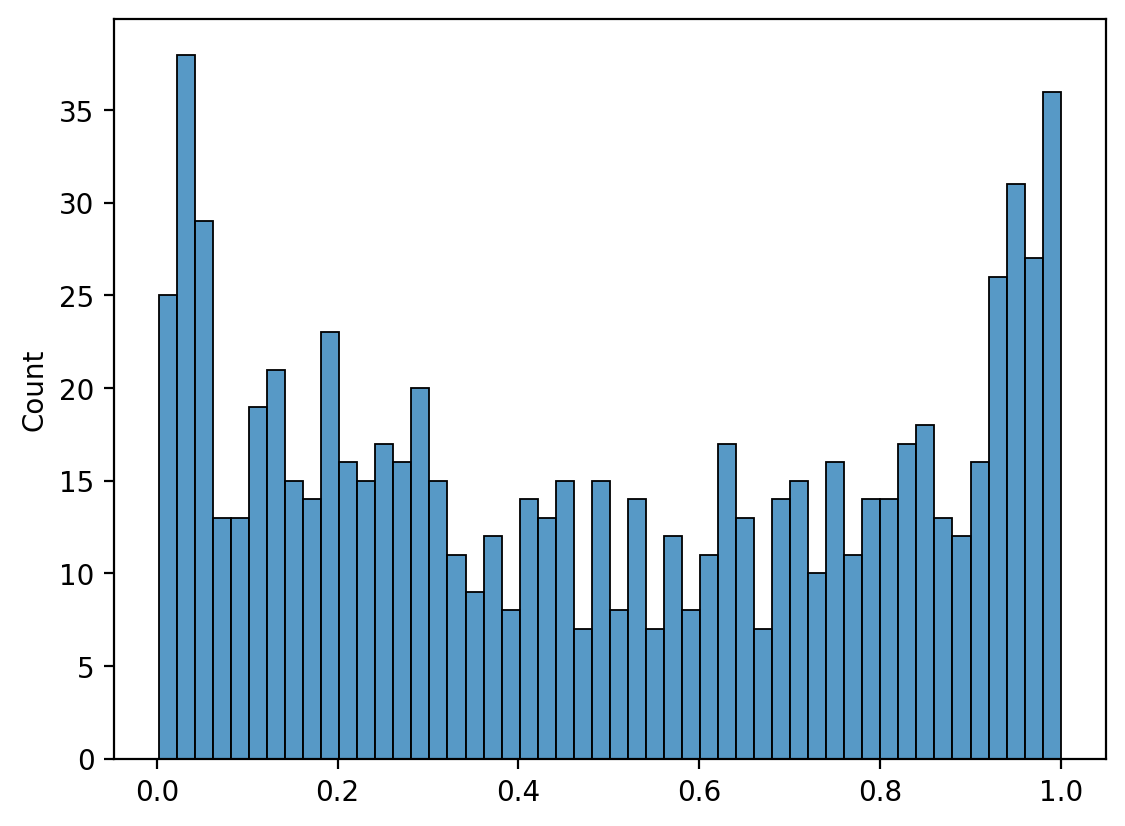

In [174]:
num_train = 800
num_test = 1_000
num_features = 200

dgenerator = datasets.LRDataset(
    dim_inputs=num_features,
    sigma=1.0,
    scale=5.0,
    condition_number=0.05
)

key = jax.random.PRNGKey(314)
key_train, key_test, key_model = jax.random.split(key, 3)

gstate, (X_train, y_train) = dgenerator.sample_train(key_train, num_train)
X_test, y_test = dgenerator.sample_test(key_test, gstate, 1_000)

y_train = jax.nn.sigmoid(y_train)
y_test = jax.nn.sigmoid(y_test)

sns.histplot(y_train, bins=50)

In [223]:
def get_acc(X, y, w):
    yhat = meanfn(w, X).ravel() > 0.5
    acc = (y > 0.5) == yhat
    return acc.mean()

def callback(bel, pred_obs, t, Xt, Yt, bel_pred, **kwargs):
    
    acc_train = get_acc(X_train, y_train, bel.mean)
    acc_test = get_acc(X_test, y_test, bel.mean)
    
    metric = {
        "train": 1 - acc_train,
        "test": 1 - acc_test
    }
    
    return metric

In [224]:
class LogReg(nn.Module):
    n_out: int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_out)(x)
        return x

In [225]:
model = LogReg(1)
params_init = model.init(key_model, X_train)
params_init, rfn = ravel_pytree(params_init)

In [226]:
def meanfn(w, x):
    log_mu = model.apply(rfn(w), x)
    mu = jax.nn.sigmoid(log_mu)
    return mu

def covfn(w, x):
    mu = meanfn(w, x)
    return mu * (1 - mu)

In [311]:
memory_sizes = [1, 20, 30, 50, 70, 100]

In [317]:
res = {}
for memory in memory_sizes:
    agent = lofi.RebayesLoFiDiagonal(
        dynamics_weights=1.0,
        dynamics_covariance=1e-7,
        emission_mean_function=meanfn,
        emission_cov_function=covfn,
        emission_dist=lambda mean, cov: tfd.Bernoulli(loc=mean),
        memory_size=memory
    )

    bel, hist = agent.scan(
        params_init, 5e-3, X_train, y_train > 0.5, progress_bar=True, callback=callback
    )
    
    res[memory] = hist
hist = jax.tree_map(np.array, hist)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

In [318]:
import pandas as pd
import seaborn as sns

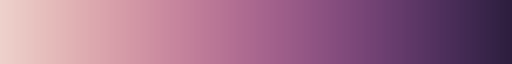

In [324]:
res_df = pd.DataFrame(utils.get_subtree(res, "test"))
res_df.index.name = "num. observations"
res_df = res_df.reset_index()
cmap = sns.cubehelix_palette(as_cmap=True)
cmap

Text(0, 0.5, 'missclassification rate')

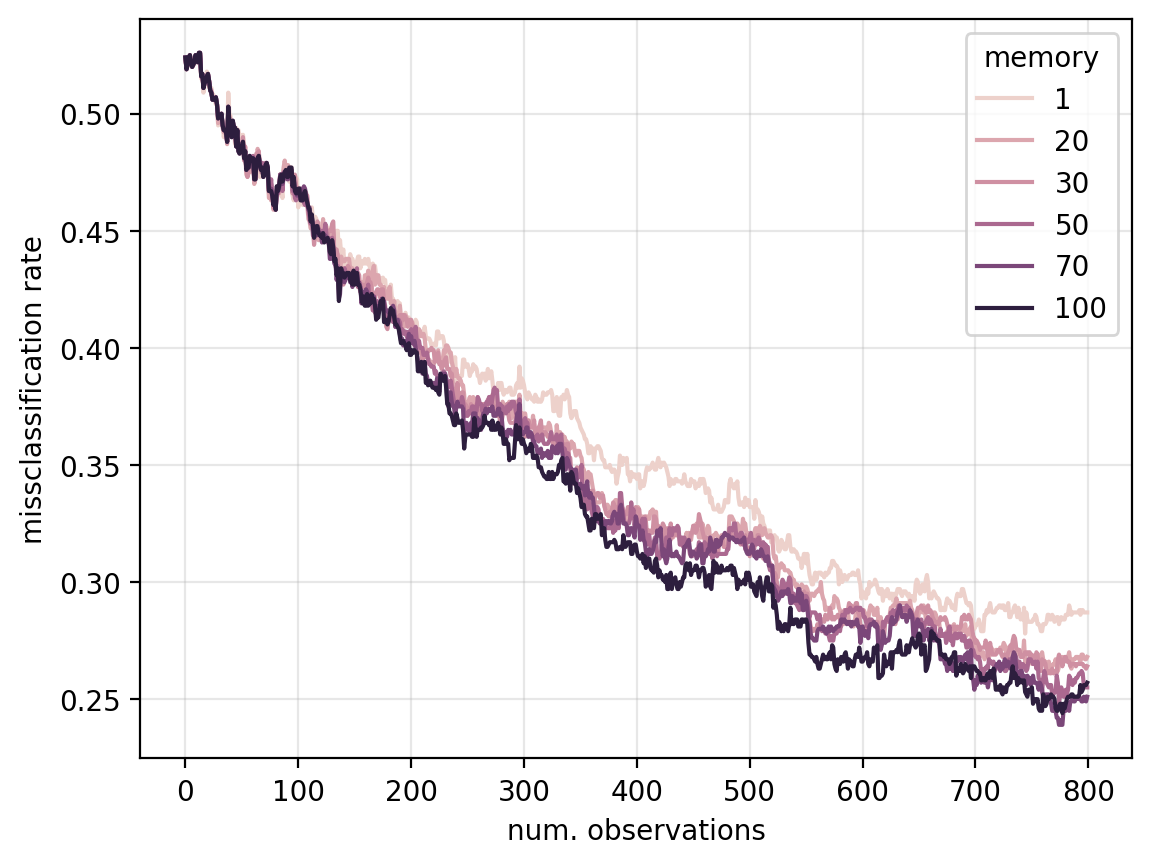

In [335]:
sns.lineplot(
    x="num. observations",
    y="value",
    hue="memory",
    data=res_df.melt(id_vars="num. observations", var_name="memory"),
    palette=cmap
)
plt.grid(alpha=0.3)
plt.ylabel("missclassification rate")

In [326]:
from rebayes.low_rank_filter import lrvga

In [329]:
import distrax

In [358]:
def fwd_link(w, bel, x):
    log_mu = model.apply(rfn(w), x)
    mu = jax.nn.sigmoid(log_mu)
    return mu, 1.0


def log_prob(mean, bel, x, y):
    mu, _ = fwd_link(mean, bel, x)
    
    logp = distrax.Bernoulli(mu).log_prob(y).sum()
    return logp

In [359]:
bel_init, reconstruct_fn = lrvga.init_lrvga(key, model, X_train, memory, std, **hparams)

In [360]:
res = {}

hparams = {
    "sigma2": 1.0,
    "eps": 1e-3 # 1e-8 gets rounded to 1.0
}

for memory in memory_sizes:
    agent = lrvga.LRVGA(
        fwd_link=fwd_link,
        log_prob=log_prob,
        n_samples=10,
    )
    
    std = 0.1
    bel_init, reconstruct_fn = lrvga.init_lrvga(key, model, X_train, memory, std, **hparams)
    bel, hist = agent.scan(
        bel_init, 5e-3, X_train, y_train > 0.5, progress_bar=True, callback=callback,
        bel=bel_init,
    )
    
    res[memory] = hist
hist = jax.tree_map(np.array, hist)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

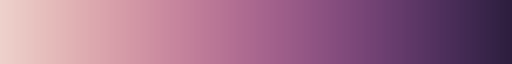

In [361]:
res_df = pd.DataFrame(utils.get_subtree(res, "test"))
res_df.index.name = "num. observations"
res_df = res_df.reset_index()
cmap = sns.cubehelix_palette(as_cmap=True)
cmap

Text(0, 0.5, 'missclassification rate')

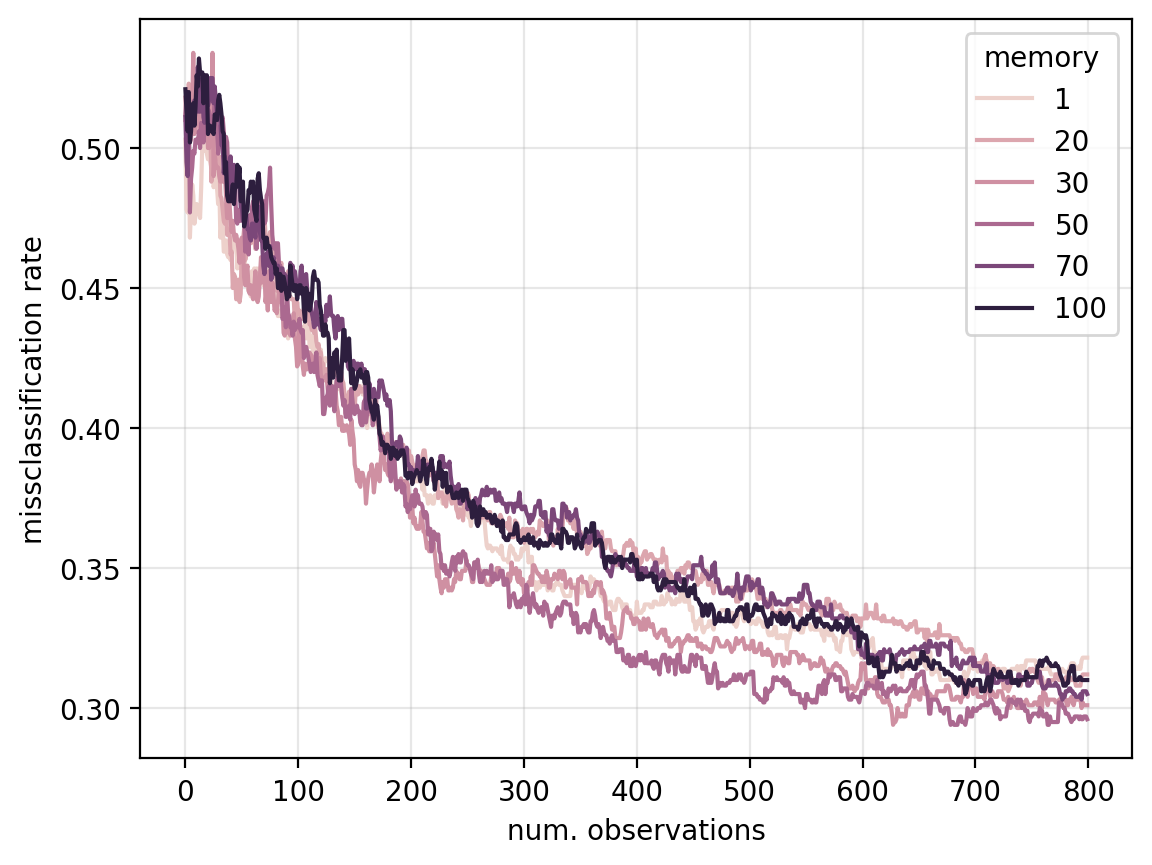

In [362]:
sns.lineplot(
    x="num. observations",
    y="value",
    hue="memory",
    data=res_df.melt(id_vars="num. observations", var_name="memory"),
    palette=cmap
)
plt.grid(alpha=0.3)
plt.ylabel("missclassification rate")

Text(0, 0.5, 'missclassification rate')

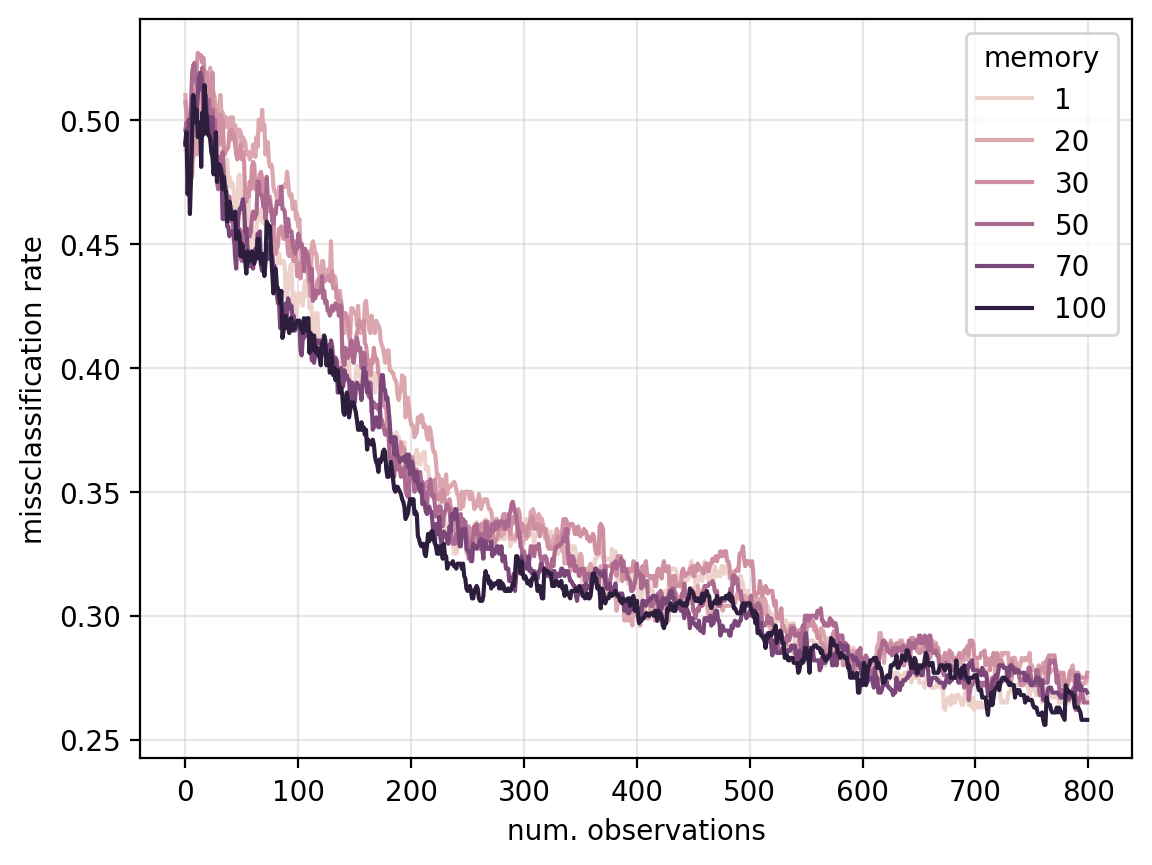

In [357]:
sns.lineplot(
    x="num. observations",
    y="value",
    hue="memory",
    data=res_df.melt(id_vars="num. observations", var_name="memory"),
    palette=cmap
)
plt.grid(alpha=0.3)
plt.ylabel("missclassification rate")